# Predicting Student Admissions

In this notebook, we predict student admissions to graduate school at UCLA based on three pieces of data:
- GRE Scores (Test)
- GPA Scores (Grades)
- Class rank (1-4)

The dataset originally came from here: http://www.ats.ucla.edu/

_Note: Thanks Adam Uccello, for helping us debug!_

## 1. Load and visualize the data

To load the data, we will use a very useful data package called Pandas. You can read on Pandas documentation here:

In [1]:
import pandas as pd
data = pd.read_csv('student_data.csv')
data.head()

,admit,gre,gpa,rank
0,0,380.0,3.61,3.0
1,1,660.0,3.67,3.0
2,1,800.0,4.00,1.0
3,1,640.0,3.19,4.0
4,0,520.0,2.93,4.0


Let's plot the data and see how it looks.

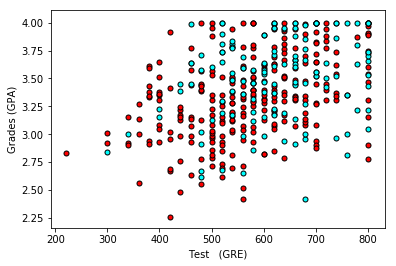

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def plot_points(data):

    X = np.array(data[["gre", "gpa"]])
    y = np.array(data["admit"])

    admitted = X[np.argwhere(y==1)]
    rejected = X[np.argwhere(y==0)]

    plt.scatter([s[0][0] for s in rejected], [s[0][1] for s in rejected], s = 25, color = 'red',  edgecolor = 'k')
    plt.scatter([s[0][0] for s in admitted], [s[0][1] for s in admitted], s = 25, color = 'cyan', edgecolor = 'k')

    plt.xlabel('Test   (GRE)')
    plt.ylabel('Grades (GPA)')

plot_points(data)
plt.show()

The data, based on only GRE and GPA scores, doesn't seem very separable. Maybe if we make a plot for each of the ranks, the boundaries will be more clear.

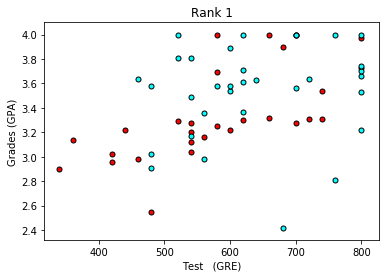

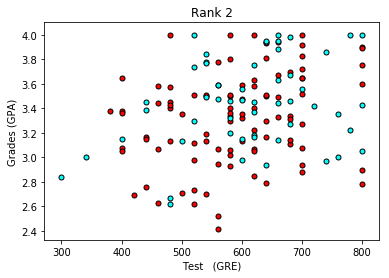

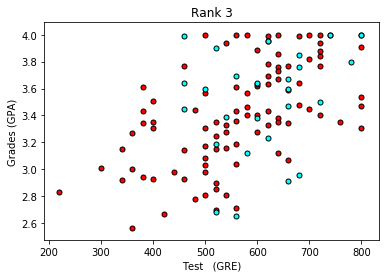

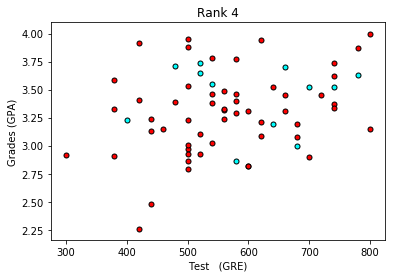

In [3]:
data_rank1 = data[data["rank"]==1]
data_rank2 = data[data["rank"]==2]
data_rank3 = data[data["rank"]==3]
data_rank4 = data[data["rank"]==4]

plot_points(data_rank1)
plt.title("Rank 1")
plt.show()
plot_points(data_rank2)
plt.title("Rank 2")
plt.show()
plot_points(data_rank3)
plt.title("Rank 3")
plt.show()
plot_points(data_rank4)
plt.title("Rank 4")
plt.show()

These plots look a bit more linearly separable, although not completely. But it seems that using a multi-layer perceptron with the rank, gre, and gpa as inputs, may give us a decent solution.

# 2. Process the data
We'll do the following steps to clean up the data for training:
- One-hot encode the rank
- Normalize the gre and the gpa scores, so they'll be in the interval (0,1)
- Split the data into the input X, and the labels y.

In [4]:
import keras
# from keras.utils import np_utils

# remove NaNs
data = data.fillna(0)

# One-hot encoding the rank
processed_data = pd.get_dummies(data, columns=['rank'])

# Normalizing the gre and the gpa scores to be in the interval (0,1)
processed_data["gre"] = processed_data["gre"] / 800
processed_data["gpa"] = processed_data["gpa"] / 4

# Splitting the data input into X, and the labels y 
X = np.array(processed_data)[:,1:].astype('float32')
y = keras.utils.to_categorical(data["admit"], 2)

Using TensorFlow backend.


In [5]:
# Checking that the input and output look correct
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
print("\nFirst 5 rows of X")
print(X[:5])
print("\nFirst 5 rows of y")
print(y[:5])

Shape of X: (400, 7)
Shape of y: (400, 2)

First 5 rows of X
[[ 0.47499999  0.90249997  0.          0.          0.          1.          0.        ]
 [ 0.82499999  0.91750002  0.          0.          0.          1.          0.        ]
 [ 1.          1.          0.          1.          0.          0.          0.        ]
 [ 0.80000001  0.79750001  0.          0.          0.          0.          1.        ]
 [ 0.64999998  0.73250002  0.          0.          0.          0.          1.        ]]

First 5 rows of y
[[ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]]


# 3. Split the data into training and testing sets

In [6]:
# break training set into training and validation sets
(X_train, X_test) = X[50:], X[:50]
(y_train, y_test) = y[50:], y[:50]

# print shape of training set
print('x_train shape:', X_train.shape)

# print number of training, validation, and test images
print(X_train.shape[0],  'training samples')
print(X_test.shape[0],  '  testing samples')

x_train shape: (350, 7)
350 training samples
50   testing samples


# 4. Define the model architecture

In [12]:
# Imports
import numpy as np
# from keras.utils import np_utils
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation

def try_model(epoch_num, optimizer="adam", batch_size=100):
    
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(7,)))
    model.add(Dropout(.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(.1))
    model.add(Dense(2, activation='softmax'))

    # Compiling the model
    if optimizer == "sgd":
        optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss = 'categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    # Training the model
    model.fit(X_train, y_train, epochs=epoch_num, batch_size=batch_size, verbose=0)

    # Evaluating the model on the training and testing set
    score = model.evaluate(X_train, y_train)
    print("\n Training Accuracy:", score[1])

    score = model.evaluate(X_test,  y_test)
    print("\n Testing Accuracy:", score[1])

# 5. Train & Score the model

In [8]:
try_model(1000)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 9,410
Trainable params: 9,410
Non-trainable params: 0
_________________________________________________________________
 32/350 [=>............................] - ETA: 0s
 Training Accuracy: 0.762857144901
32/50 [==================>...........] - ETA: 0s
 Test

# 6. Define the function for model building

# 7. Play with parameters!
You can see that we made several decisions in our training. For instance, the number of layers, the sizes of the layers, the number of epochs, etc.

It's your turn to play with parameters! Can you improve the accuracy? The following are other suggestions for these parameters. We'll learn the definitions later in the class:
- Activation function: relu and sigmoid
- Loss function: categorical_crossentropy, mean_squared_error
- Optimizer: rmsprop, adam, ada

## epochs=50000:
Training Accuracy: 0.922857140473
Testing  Accuracy: 0.560000001192

## epochs=5000:
Training Accuracy: 0.845714286736
Testing  Accuracy: 0.619999997616

In [9]:
try_model(5000)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               1024      
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 130       
Total params: 9,410
Trainable params: 9,410
Non-trainable params: 0
_________________________________________________________________
 32/350 [=>............................] - ETA: 1s
 Training Accuracy: 0.831428570066
32/50 [==================>...........] - ETA: 0s
 Test

In [13]:
try_model(50000)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 128)               1024      
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 130       
Total params: 9,410
Trainable params: 9,410
Non-trainable params: 0
_________________________________________________________________
 32/350 [=>............................] - ETA: 0s
 Training Accuracy: 0.928571426528
32/50 [==================>...........] - ETA: 0s
 Test

In [14]:
try_model(1000, "sgd")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 128)               1024      
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 130       
Total params: 9,410
Trainable params: 9,410
Non-trainable params: 0
_________________________________________________________________
 32/350 [=>............................] - ETA: 0s
 Training Accuracy: 0.722857144901
32/50 [==================>...........] - ETA: 0s
 Test

In [15]:
try_model(5000, "sgd")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 128)               1024      
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_14 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 2)                 130       
Total params: 9,410
Trainable params: 9,410
Non-trainable params: 0
_________________________________________________________________
 32/350 [=>............................] - ETA: 0s
 Training Accuracy: 0.794285715989
32/50 [==================>...........] - ETA: 0s
 Test

In [16]:
try_model(50000, "sgd")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 128)               1024      
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_16 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 2)                 130       
Total params: 9,410
Trainable params: 9,410
Non-trainable params: 0
_________________________________________________________________
 32/350 [=>............................] - ETA: 1s
 Training Accuracy: 0.914285712242
32/50 [==================>...........] - ETA: 0s
 Test